In [7]:
!pip install pymc arviz --quiet


In [8]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd


In [9]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded.keys())))
df.head()


Saving project_data.csv to project_data.csv


,Age,Income,Duration_Months,Success
0,44,80990,10.363449,1
1,38,73869,2.518226,1
2,46,60894,9.022872,0
3,55,50295,3.552956,1
4,37,70473,19.589410,1


In [10]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              1000 non-null   int64  
 1   Income           1000 non-null   int64  
 2   Duration_Months  1000 non-null   float64
 3   Success          1000 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 31.4 KB


In [14]:
 # Target variable (binary outcome)
y = df['Success'].values

# Predictor variables
X = df[['Age', 'Income', 'Duration_Months']].values



In [15]:
import pymc as pm
import arviz as az
import numpy as np

with pm.Model() as logistic_model:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=X.shape[1])

    linear_combination = intercept + pm.math.dot(X, coeffs)
    p = pm.Deterministic('p', pm.math.sigmoid(linear_combination))

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)

    trace = pm.sample(1000, tune=1000, target_accept=0.9)


Output()

In [16]:
az.summary(trace, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeffs[0],0.07,0.01,0.05,0.08,0.00,0.00,897.92,951.41,1.0
coeffs[1],0.00,0.00,0.00,0.00,0.00,0.00,1034.04,966.72,1.0
coeffs[2],0.11,0.01,0.09,0.14,0.00,0.00,1379.19,1076.44,1.0
intercept,-4.67,0.53,-5.70,-3.68,0.02,0.01,766.50,959.60,1.0
p[0],0.83,0.02,0.80,0.87,0.00,0.00,1152.32,1208.68,1.0
...,...,...,...,...,...,...,...,...,...
p[995],0.70,0.02,0.65,0.74,0.00,0.00,1534.00,1508.06,1.0
p[996],0.96,0.01,0.94,0.98,0.00,0.00,983.91,1200.67,1.0
p[997],0.56,0.03,0.49,0.62,0.00,0.00,1522.23,1486.30,1.0
p[998],0.37,0.03,0.32,0.43,0.00,0.00,1128.73,1185.53,1.0


array([[<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

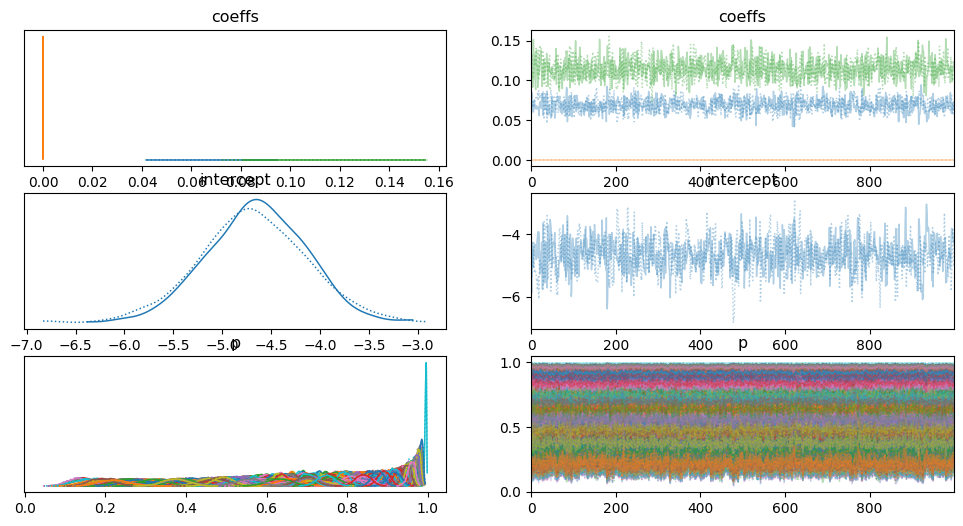

In [17]:
az.plot_trace(trace)


array([[<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

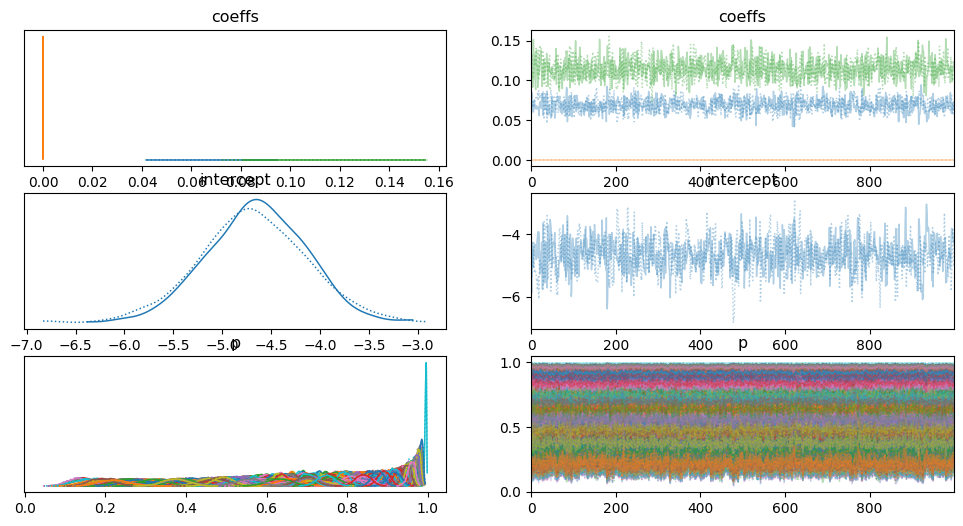

In [18]:
import arviz as az
az.plot_trace(trace)


array([<Axes: title={'center': 'coeffs\n0'}>,
       <Axes: title={'center': 'coeffs\n1'}>,
       <Axes: title={'center': 'coeffs\n2'}>,
       <Axes: title={'center': 'intercept'}>], dtype=object)

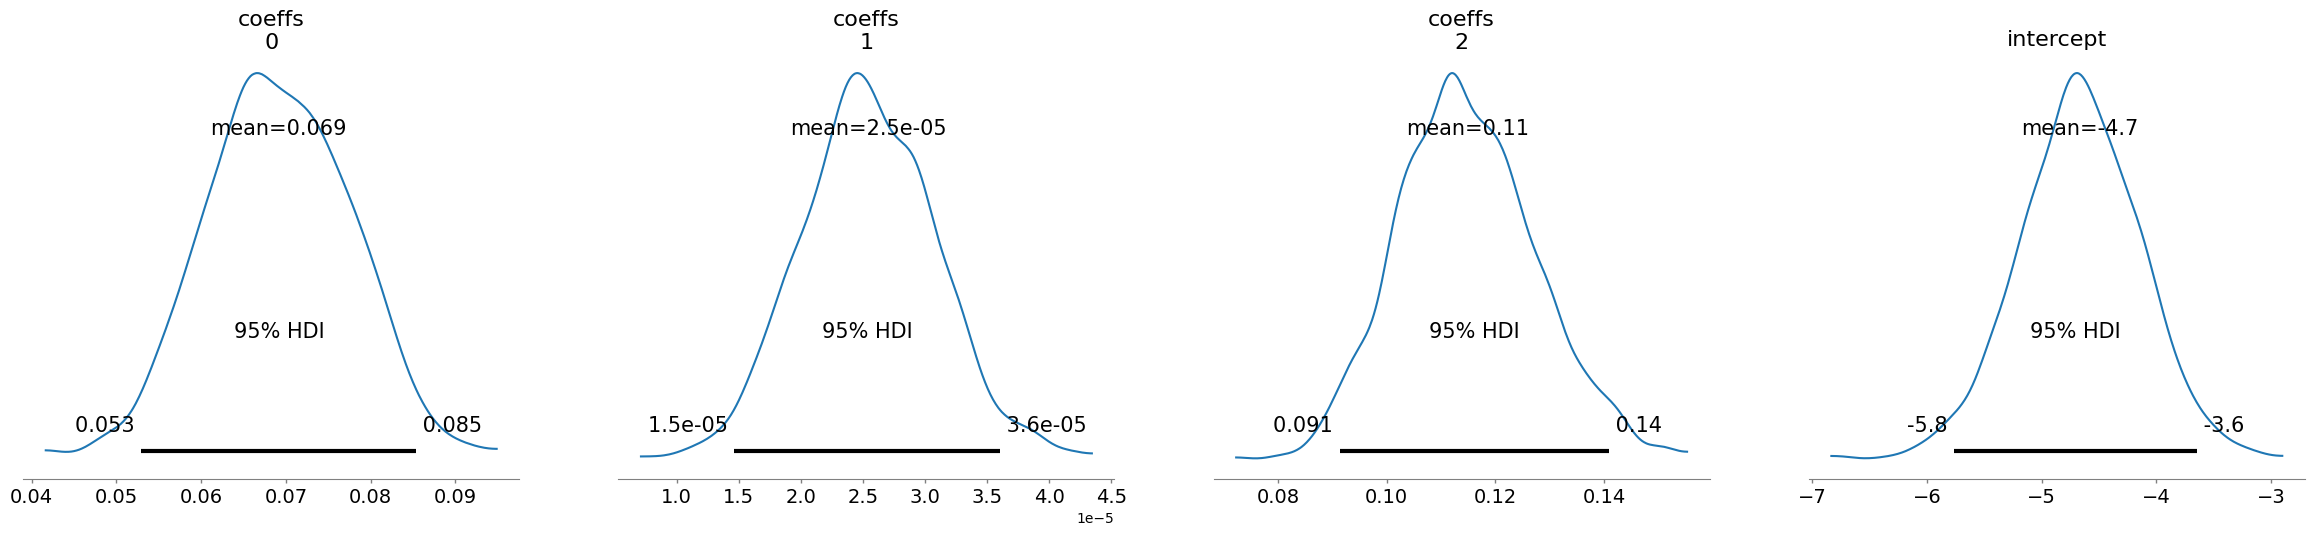

In [19]:
az.plot_posterior(trace, var_names=['coeffs', 'intercept'], hdi_prob=0.95)


In [20]:
import numpy as np

# Extract posterior mean of coefficients and intercept
coeff_means = trace.posterior['coeffs'].mean(dim=['chain', 'draw']).values
intercept_mean = trace.posterior['intercept'].mean(dim=['chain', 'draw']).values

def predict_prob(X):
    log_odds = intercept_mean + np.dot(X, coeff_means)
    odds = np.exp(log_odds)
    return odds / (1 + odds)

# Example: predict for the first 5 rows of your dataset
X_sample = df[['Age', 'Income', 'Duration_Months']].values[:5]
predicted_probs = predict_prob(X_sample)
print(predicted_probs)


[0.83569811 0.53236588 0.75018309 0.69511912 0.87372252]


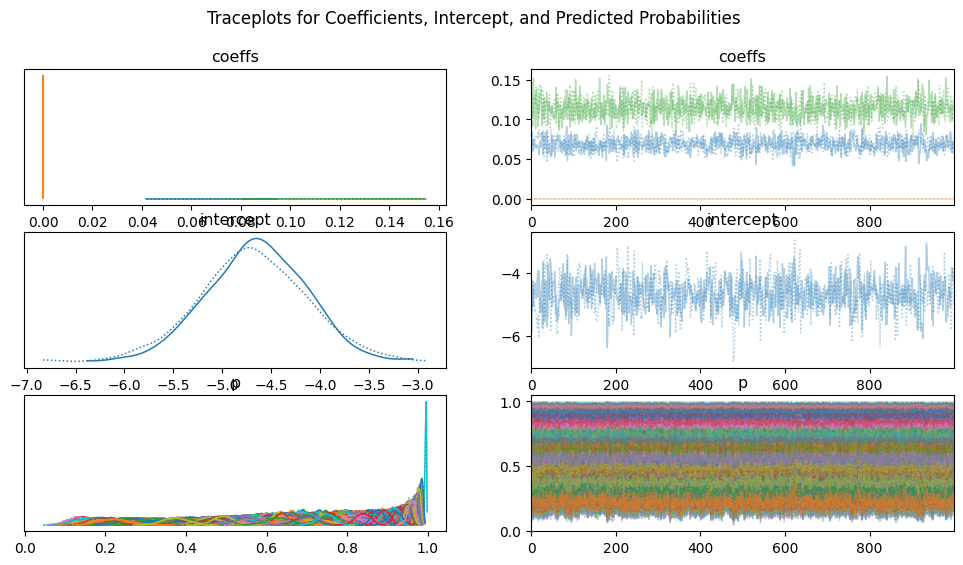

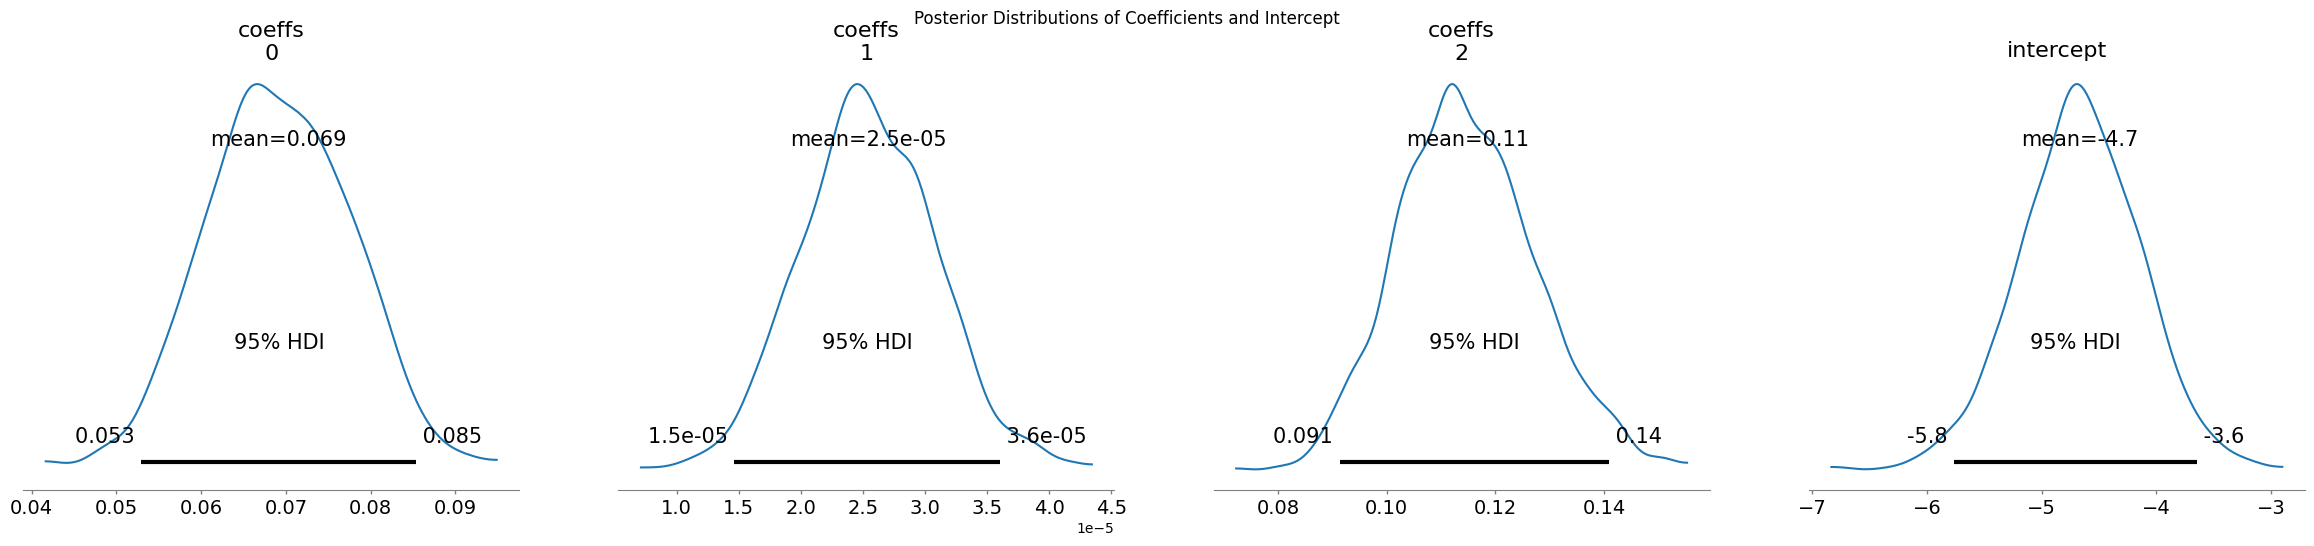

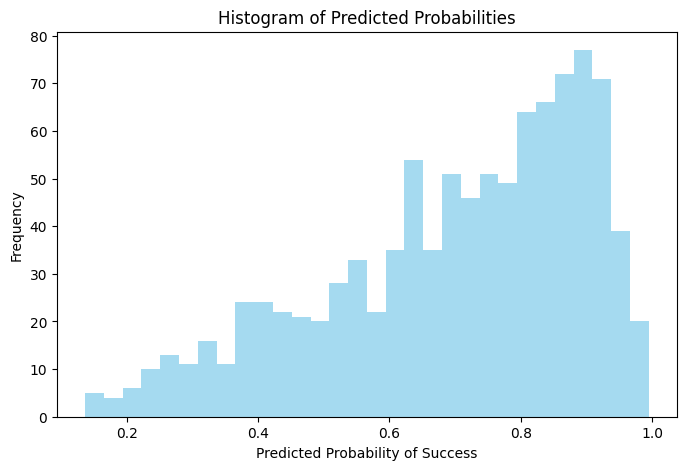

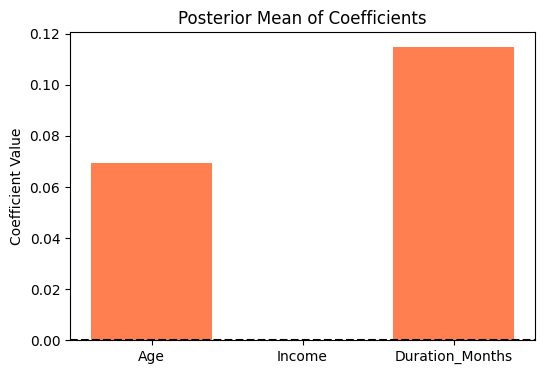

In [21]:
import arviz as az
import matplotlib.pyplot as plt

# 1. Traceplots for MCMC diagnostics
az.plot_trace(trace, var_names=['coeffs', 'intercept', 'p'])
plt.suptitle('Traceplots for Coefficients, Intercept, and Predicted Probabilities')
plt.show()

# 2. Posterior distributions for coefficients and intercept
az.plot_posterior(trace, var_names=['coeffs', 'intercept'], hdi_prob=0.95)
plt.suptitle('Posterior Distributions of Coefficients and Intercept')
plt.show()

# 3. Plot predicted probabilities histogram
pred_probs = trace.posterior['p'].mean(dim=['chain', 'draw']).values

plt.figure(figsize=(8, 5))
plt.hist(pred_probs, bins=30, alpha=0.75, color='skyblue')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Success')
plt.ylabel('Frequency')
plt.show()

# 4. Optional: Coefficients barplot (posterior means)
import numpy as np

coeff_means = trace.posterior['coeffs'].mean(dim=['chain', 'draw']).values
intercept_mean = trace.posterior['intercept'].mean(dim=['chain', 'draw']).values

plt.figure(figsize=(6, 4))
plt.bar(['Age', 'Income', 'Duration_Months'], coeff_means, color='coral')
plt.axhline(0, color='black', linestyle='--')
plt.title('Posterior Mean of Coefficients')
plt.ylabel('Coefficient Value')
plt.show()


In [23]:
import pymc as pm
import arviz as az

print(pm.__version__)
print(az.__version__)


5.25.1
0.22.0


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coeffs[0]  0.07  0.01    0.05     0.08       0.00     0.00    897.92   
coeffs[1]  0.00  0.00    0.00     0.00       0.00     0.00   1034.04   
coeffs[2]  0.11  0.01    0.09     0.14       0.00     0.00   1379.19   
intercept -4.67  0.53   -5.70    -3.68       0.02     0.01    766.50   
p[0]       0.83  0.02    0.80     0.87       0.00     0.00   1152.32   
...         ...   ...     ...      ...        ...      ...       ...   
p[995]     0.70  0.02    0.65     0.74       0.00     0.00   1534.00   
p[996]     0.96  0.01    0.94     0.98       0.00     0.00    983.91   
p[997]     0.56  0.03    0.49     0.62       0.00     0.00   1522.23   
p[998]     0.37  0.03    0.32     0.43       0.00     0.00   1128.73   
p[999]     0.75  0.02    0.70     0.79       0.00     0.00   1648.98   

           ess_tail  r_hat  
coeffs[0]    951.41    1.0  
coeffs[1]    966.72    1.0  
coeffs[2]   1076.44    1.0  
intercept    959.60

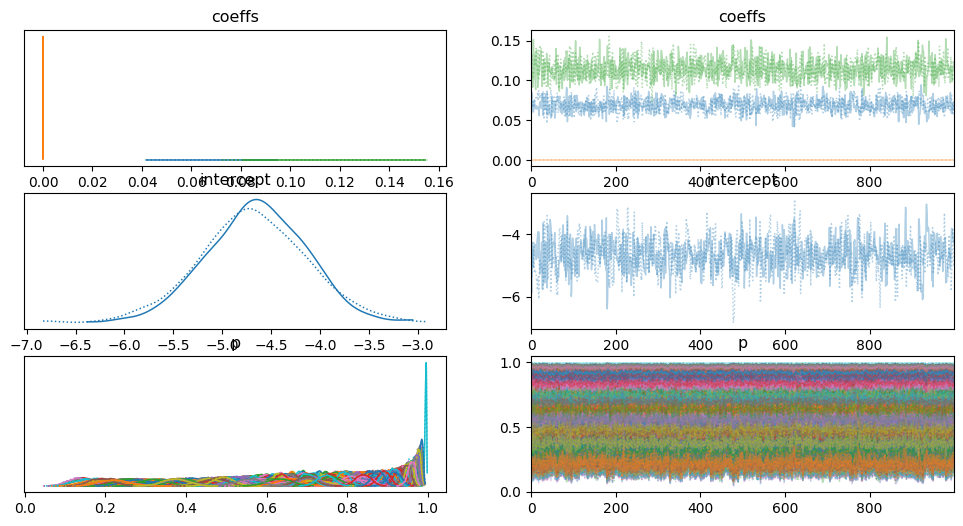

In [27]:
import arviz as az

az.plot_trace(trace)
print(az.summary(trace, round_to=2))


In [28]:
import numpy as np

# Assuming you have coefficients posterior samples as numpy arrays:
coeff_samples = trace.posterior['coeffs'].stack(sample=["chain", "draw"]).values  # shape (n_coeffs, n_samples)
intercept_samples = trace.posterior['intercept'].stack(sample=["chain", "draw"]).values  # shape (n_samples,)

# Generate predicted probabilities for each sample (example for logistic regression)
def logistic(x):
    return 1 / (1 + np.exp(-x))

X = df[['Age', 'Income', 'Duration_Months']].values  # your predictors matrix

ppc_samples = []
for i in range(coeff_samples.shape[1]):
    linear_pred = intercept_samples[i] + np.dot(X, coeff_samples[:, i])
    p = logistic(linear_pred)
    y_sim = np.random.binomial(n=1, p=p)
    ppc_samples.append(y_sim)

ppc_samples = np.array(ppc_samples)  # shape (n_samples, n_data_points)

# Compare means:
print("Observed mean:", df['Success'].mean())
print("Simulated means:", ppc_samples.mean(axis=1).mean())


Observed mean: 0.699
Simulated means: 0.698991


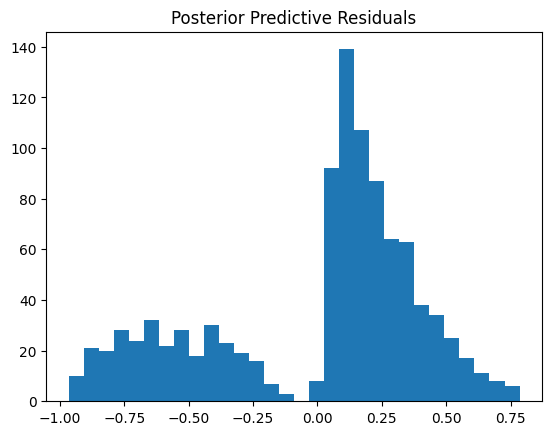

In [29]:
obs = df['Success'].values
pred_means = ppc_samples.mean(axis=0)

residuals = obs - pred_means
import matplotlib.pyplot as plt

plt.hist(residuals, bins=30)
plt.title("Posterior Predictive Residuals")
plt.show()


In [31]:
r2 = az.r2_score(df['Success'].values, ppc_samples.mean(axis=0))
print("Bayesian R²:", r2)


Bayesian R²: r2        0.187618
r2_std    0.000000
dtype: float64


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


In [33]:
# Assuming your DataFrame is named df
X = df[['Age', 'Income', 'Duration_Months']]
y = df['Success']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [35]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
# L2 penalty is the default in sklearn's LogisticRegression
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
lr_l2.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

In [37]:
y_pred_l2 = lr_l2.predict(X_test_scaled)
y_prob_l2 = lr_l2.predict_proba(X_test_scaled)[:, 1]

print("L2 Regularized Logistic Regression:")
print(classification_report(y_test, y_pred_l2))
print("ROC AUC:", roc_auc_score(y_test, y_prob_l2))
print("Accuracy:", accuracy_score(y_test, y_pred_l2))


L2 Regularized Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.42      0.52        60
           1       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200

ROC AUC: 0.735
Accuracy: 0.765


In [38]:
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lr_l1.fit(X_train_scaled, y_train)


LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [39]:
y_pred_l1 = lr_l1.predict(X_test_scaled)
y_prob_l1 = lr_l1.predict_proba(X_test_scaled)[:, 1]

print("L1 Regularized Logistic Regression:")
print(classification_report(y_test, y_pred_l1))
print("ROC AUC:", roc_auc_score(y_test, y_prob_l1))
print("Accuracy:", accuracy_score(y_test, y_pred_l1))


L1 Regularized Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.42      0.52        60
           1       0.79      0.91      0.84       140

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.75      0.77      0.75       200

ROC AUC: 0.7351190476190477
Accuracy: 0.765


In [40]:
features = ['Age', 'Income', 'Duration_Months']

print("L2 Coefficients:")
for f, coef in zip(features, lr_l2.coef_[0]):
    print(f"{f}: {coef:.4f}")

print("\nL1 Coefficients:")
for f, coef in zip(features, lr_l1.coef_[0]):
    print(f"{f}: {coef:.4f}")


L2 Coefficients:
Age: 0.6333
Income: 0.3935
Duration_Months: 0.7891

L1 Coefficients:
Age: 0.6294
Income: 0.3882
Duration_Months: 0.7867


In [41]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming your data is in a pandas DataFrame called df
features = ['Age', 'Income', 'Duration_Months']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Convert back to DataFrame for convenience (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Prepare response variable
y = df['Success'].values


In [42]:
import pymc as pm
import arviz as az

with pm.Model() as model_standardized:
    # Priors for coefficients (normal with mean=0, sd=1 for regularization)
    coeffs = pm.Normal("coeffs", mu=0, sigma=1, shape=len(features))
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    # Logistic regression linear predictor
    logits = intercept + pm.math.dot(X_scaled, coeffs)

    # Likelihood (Bernoulli)
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)

    # Sample posterior
    trace_standardized = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

In [43]:
summary = az.summary(trace_standardized, var_names=['coeffs', 'intercept'], round_to=3)
print(summary)


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coeffs[0]  0.669  0.082   0.520    0.826      0.001    0.001  4318.563   
coeffs[1]  0.378  0.078   0.231    0.522      0.001    0.001  4207.682   
coeffs[2]  0.758  0.084   0.602    0.915      0.001    0.001  3691.028   
intercept  1.047  0.081   0.894    1.201      0.001    0.001  4210.056   

           ess_tail  r_hat  
coeffs[0]  3162.714  1.000  
coeffs[1]  2891.908  1.001  
coeffs[2]  2492.030  1.000  
intercept  3103.425  1.000  


In [44]:
import numpy as np

summary['odds_ratio_mean'] = np.exp(summary['mean'])
summary['odds_ratio_hdi_3%'] = np.exp(summary['hdi_3%'])
summary['odds_ratio_hdi_97%'] = np.exp(summary['hdi_97%'])

print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'odds_ratio_mean', 'odds_ratio_hdi_3%', 'odds_ratio_hdi_97%']])


            mean     sd  hdi_3%  hdi_97%  odds_ratio_mean  odds_ratio_hdi_3%  \
coeffs[0]  0.669  0.082   0.520    0.826         1.952284           1.682028   
coeffs[1]  0.378  0.078   0.231    0.522         1.459363           1.259859   
coeffs[2]  0.758  0.084   0.602    0.915         2.134004           1.825767   
intercept  1.047  0.081   0.894    1.201         2.849091           2.444890   

           odds_ratio_hdi_97%  
coeffs[0]            2.284164  
coeffs[1]            1.685395  
coeffs[2]            2.496775  
intercept            3.323439  
